In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

parent = os.path.abspath(os.path.join(os.getcwd(), '..'))
party_the_3rd = os.path.join(parent, 'third_party')
for path_ in [parent, party_the_3rd]:
    if path_ not in (cur_path:=sys.path):
        sys.path = [path_] + cur_path
print(sys.path)


import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

import shampoo
import kradagrad


['/home/jmei/code/experiments/kradagrad/third_party', '/home/jmei/code/experiments/kradagrad', '/home/jmei/code/experiments/kradagrad/experiments', '/home/jmei/miniconda3/envs/krad/lib/python310.zip', '/home/jmei/miniconda3/envs/krad/lib/python3.10', '/home/jmei/miniconda3/envs/krad/lib/python3.10/lib-dynload', '', '/home/jmei/miniconda3/envs/krad/lib/python3.10/site-packages']


/home/jmei/miniconda3/envs/krad/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# problem sizes
X_sz = 4
Y_sz = 2
batch_sz = 32
N_tr = 1_024
N_va = 128

# model hyperparams
mlp_sizes = [X_sz, 8, 8, Y_sz]
loss_fn = torch.nn.MSELoss()

# MLP def
def model_maker(mlp_sizes, seed):
    torch.manual_seed(seed)  # reproducible
    layers = []
    for i_ in range(1, len(mlp_sizes)):
        layers.append(torch.nn.Linear(mlp_sizes[i_ - 1], mlp_sizes[i_]))
        layers.append(torch.nn.Softplus())
    model = torch.nn.Sequential(*layers[:-1])
    return model

# use cuda?
#cuda = True
cuda = False

seed_gt = 4750
# create MLP
model = model_maker(mlp_sizes, seed_gt)

if cuda:
    import torch.multiprocessing as mp
    mp.set_start_method('spawn')
    model.cuda()

#we don't really need gt params for anything:
#params_gt = list(x.detach() for x in model.parameters())

# gen data
# non-diagonal data distribution
U = torch.randn((X_sz, X_sz))
U = torch.triu(U)

X = torch.randn((N_tr+N_va, X_sz)).mm(U.T)

if cuda:
    X = X.cuda()
Y = model(X)

dataloader_tr = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X[:N_tr], Y[:N_tr]), batch_size=batch_sz, shuffle=True)
dataloader_va = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X[N_tr:], Y[N_tr:]), batch_size=batch_sz, shuffle=False)

In [3]:
# repeatable training run for different optimizers
def simple_train_run(model, loss_fn, n_it, opt, val_int, exp_name='', dir_name = '', retain_graph=False, dataloader_tr=dataloader_tr, dataloader_va=dataloader_va):
    os.makedirs(dir_name, exist_ok=True)
    tr_fn = os.path.join(dir_name, '{}_loss_tr.npy'.format(exp_name))
    va_fn = os.path.join(dir_name, '{}_loss_va.npy'.format(exp_name))
    if os.path.isfile(tr_fn) and os.path.isfile(va_fn):
        print('  already trained. loading: {}, {}'.format(tr_fn, va_fn))
        loss_tr, loss_va = np.load(tr_fn), np.load(va_fn)
        return loss_tr, loss_va
    n_tr = len(dataloader_tr.dataset)
    n_va = len(dataloader_va.dataset)
    model.train()
    
    loss_tr = []
    loss_va = []
    for it_ in tqdm(range(n_it), 'Epoch', ncols=80):
        loss_tr_this = 0
        for i_, (X_b, Y_b) in enumerate(dataloader_tr):
            Y_hat = model(X_b)
            err = loss_fn(Y_hat, Y_b)
            with torch.no_grad():
                loss_tr_this += err.item()
            opt.zero_grad()
            err.backward(retain_graph=retain_graph)
            opt.step()
        loss_tr.append(loss_tr_this / n_tr)
        
        # validation loss
        if it_ % val_int == (val_int - 1):
            model.eval()
            loss_va_this = 0
            for i_, (X_b, Y_b) in enumerate(dataloader_va):
                with torch.no_grad():
                    Y_hat = model(X_b)
                    err = loss_fn(Y_hat, Y_b)
                    loss_va_this += err.item()
            loss_va.append(loss_va_this / n_va)
            model.train()
    np.save(tr_fn, loss_tr)
    np.save(va_fn, loss_va)
    return loss_tr, loss_va

In [6]:
# common optimizer hyperparams

lr_str = '1e-3'
lr_str = '5e-3'
lr_str = '1e-2'
lr_str = '5e-2'
lr_str = '1e-1'

lr_str = '8e-2'

lr = eval(lr_str)
seed_exp = 95054


#### This is important for all methods! At least on these small problems
# Large enough --> good performance
eps_adam_str = '1e-1'
eps_str = '1e-6'

eps_adam_str = '1e-1'
eps_str = '1e-4'
eps_adam = eval(eps_adam_str)
eps = eval(eps_str)



# training settings
n_it = 640
val_int = 4
it_val = [x for x in range(n_it) if x % val_int == val_int - 1]


# Optimizers: being clever about initializing mangles classes and initialization for some reason
opt_names = [
    'shampoo_eps{}'.format(eps_str)
]
hps = [shampoo.ShampooHyperParams(diagonal_eps=eps, block_size=8,
    matrix_eps=m_, graft_type=g_, beta2=be_
) for (m_, g_, be_) in (
    [1e-6, 0, 1],          # Shampoo
    #[1e-6, 3, 0.999],     # Shampoo 0.999 adamgraft
)]
opts = [(lambda params: shampoo.Shampoo(params, lr=lr, hyperparams=hp_)) for hp_ in hps]


opt_names = opt_names + [
    'krad_eps{}'.format(eps_str)
]
hps = [shampoo.ShampooHyperParams(diagonal_eps=eps, block_size=8,
    matrix_eps=m_, graft_type=g_, beta2=be_
) for (m_, g_, be_) in (
    [1e0, 0, 1],           # Krad
    #[1e0, 3, 0.999],       # Krad 0.999 adamgraft
)]
opts = opts + [(lambda params: kradagrad.KradagradPP(params, lr=lr, hyperparams=hp_)) for hp_ in hps]

opt_names = opt_names + [
    'adam_eps{}'.format(eps_adam_str)
]
opts = opts + [lambda params: torch.optim.Adam(params, lr=lr, eps=eps_adam)]


dir_name = 'mlp_softplus_all'
loss_tr = {}
loss_va = {}
for opt_name_, opt_ in zip(opt_names, opts):
    print('Using {}'.format(opt_name_))
    del model
    model = model_maker(mlp_sizes, seed_exp)
    exp_name_ = 'lr{}'.format(lr_str)
    if cuda:
        model.cuda()
        exp_name_ = '{}_cuda'.format(exp_name_)
    exp_name_ = '{}_{}'.format(exp_name_, opt_name_)
    opt = opt_(model.parameters())

    # `retain_graph` still required for some reason... haven't figured out why
    try:
        loss_tr_, loss_va_ = simple_train_run(
            model, loss_fn, n_it, opt, 
            val_int, exp_name=exp_name_, dir_name=dir_name, retain_graph=True
        )
        loss_tr[opt_name_] = loss_tr_
        loss_va[opt_name_] = loss_va_
    except Exception as err:
        print('error: {}'.format(err))


Using shampoo_eps1e-4
  already trained. loading: mlp_softplus_all/lr8e-2_shampoo_eps1e-4_loss_tr.npy, mlp_softplus_all/lr8e-2_shampoo_eps1e-4_loss_va.npy
Using krad_eps1e-4
  already trained. loading: mlp_softplus_all/lr8e-2_krad_eps1e-4_loss_tr.npy, mlp_softplus_all/lr8e-2_krad_eps1e-4_loss_va.npy
Using adam_eps1e-1


Epoch: 100%|██████████████████████████████████| 640/640 [00:33<00:00, 19.24it/s]


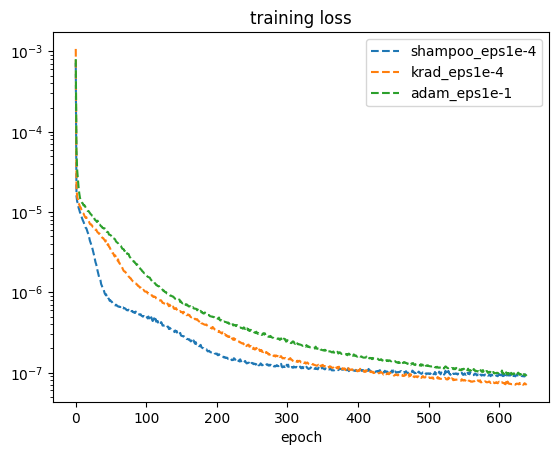

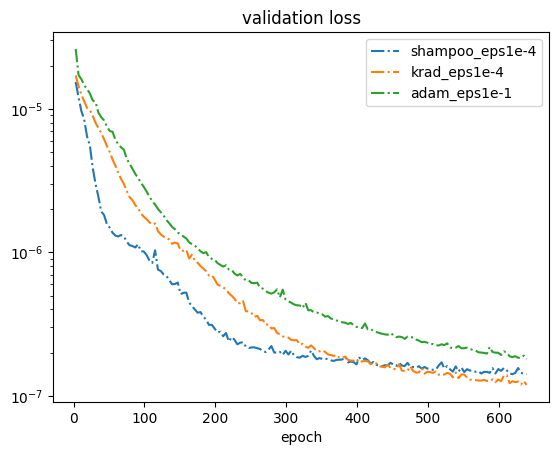

In [7]:
# plot all
plt.figure()
for opt_name_ in opt_names:
    plt.semilogy(range(n_it), loss_tr[opt_name_], '--')
plt.legend(opt_names)
plt.xlabel('epoch')
plt.title('training loss')

plt.figure()
for opt_name_ in opt_names:
    plt.semilogy(it_val, loss_va[opt_name_], '-.')
plt.legend(opt_names)
plt.xlabel('epoch')
plt.title('validation loss')

plt.show()

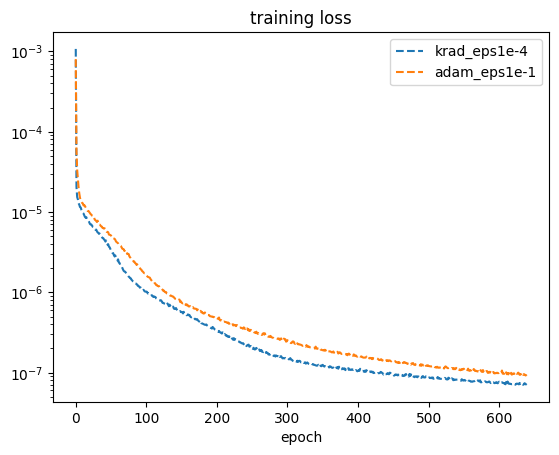

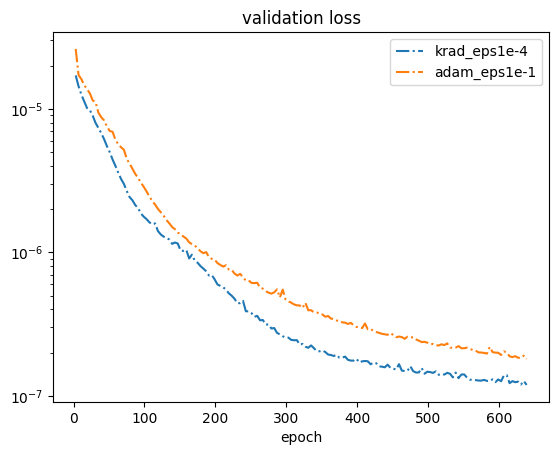

In [11]:
# select specific ones to compare
compare_names = [
    #'shampoo_eps{}'.format(eps_str), #'shampoo0_9_graft',
    'krad_eps{}'.format(eps_str), #'krad0_9_graft',
    'adam_eps{}'.format(eps_adam_str),
]

plt.figure()
for opt_name_ in compare_names:
    plt.semilogy(range(len(loss_tr[opt_name_])), loss_tr[opt_name_], '--')
plt.legend(compare_names)
#plt.ylim([5e-5,1e-3])
plt.xlabel('epoch')
plt.title('training loss')

plt.figure()
for opt_name_ in compare_names:
    plt.semilogy(it_val[:len(loss_va[opt_name_])], loss_va[opt_name_], '-.')
plt.legend(compare_names)
#plt.ylim([5e-5,1e-3])
#plt.xlim([0,100])
plt.xlabel('epoch')
plt.title('validation loss')

plt.show()